## 8. Simple Stats

In today's class we will do some basic analysis of weather data.

Our source of data will be the <a href="http://climate.weather.gc.ca/historical_data/search_historic_data_e.html">Canadian Weather Database</a>.

First, we write some code to collate all our downloads into one common Python object. 
We will build in a *sanity check* to ensure we know of any gaps in our data.

In [1]:
import os as os
import fnmatch as fn ## library for listing files matching
  ##  *blah* all files with word blah in its name
  ##  wildcard matching
import collections as co

wsubdir = fn.filter(os.listdir('../data'), "w.*")

## manipulated dates and times 
import datetime as dt


In [2]:
print("Weather subdirectories: ",wsubdir)

Weather subdirectories:  ['w.sask', 'w.vic']


In [4]:
## go through the subdirectories data/wsubdir[]
## load the files, then process them into a data type
## basic line formatting
def fmtline(ln):
    PL = ln.translate({ord(c): None for c in '"\n'})
    PL = PL.split(",")
    return(PL)

In [6]:
## we can store it as a co.defaultdict(dict)
## we want to do this to ensure if the key list has different order
## in different files, using a co.defaultdict(list) could be unstable.

## location == weather station name
## format addDat["location"][date][dict key]
initDat = co.defaultdict(dict)

for wd in wsubdir:
    files = fn.filter(os.listdir('../data/'+wd), "eng-daily*.csv")
    for wdf in files:
        with open('../data/'+wd+'/'+wdf, encoding='utf-8') as f:
            content = f.readlines()

            ## find line describing columns
            keylines = [i for i in range(len(content)) if 'date/time' in content[i].lower()]
            
            
#             if len(keylines)!=1:
#                 print("Error: "+wd+'/'+wdf+" key error. ")
#                 () = () + 1 ## cute way to get jupyter to crash.

            ## find station data
            stnlines = [i for i in range(len(content)) if 'station name' in content[i].lower()]
#             print(stnlines)
#             print(keylines)
            
            
#             if len(stnlines)!=1:
#                 print("Error: "+wd+'/'+wdf+" stn name error. ")
#                 () = () + 1

            airpt = fmtline(content[stnlines[0]])[1]
            keys = fmtline(content[keylines[0]])
        
            ## get date/time index
            dti = [i for i in range(len(keys)) if 'date/time' in keys[i].lower()]
            
#             if len(dti)!=1:
#                 print("Error: "+wd+'/'+wdf+' date/time idx. ')
#                 () = () + 1

            ## let's collect the data
            for i in range(keylines[0]+1, len(content)):
                ln = fmtline(content[i])
                ## convert date/time to python datetime object
                ln[dti[0]] = dt.datetime.strptime(ln[dti[0]], "%Y-%m-%d")

                initDat[airpt][ln[dti[0]]] = dict( [ (keys[i] , ln[i]) for i in range(len(keys)) if i != dti[0] ] )

In [7]:
print(initDat.keys())
## weather stations

dict_keys(["SASKATOON DIEFENBAKER INT'L A", 'SASKATOON RCS', 'SASKATOON INTL A', "VICTORIA INT'L A", 'VICTORIA INTL A'])


In [9]:
initDat["SASKATOON DIEFENBAKER INT'L A"][dt.datetime.strptime("1985-1-1","%Y-%m-%d")]

{'Year': '1985',
 'Month': '01',
 'Day': '01',
 'Data Quality': '',
 'Max Temp (°C)': '-11.0',
 'Max Temp Flag': '',
 'Min Temp (°C)': '-32.4',
 'Min Temp Flag': '',
 'Mean Temp (°C)': '-21.7',
 'Mean Temp Flag': '',
 'Heat Deg Days (°C)': '39.7',
 'Heat Deg Days Flag': '',
 'Cool Deg Days (°C)': '0.0',
 'Cool Deg Days Flag': '',
 'Total Rain (mm)': '0.0',
 'Total Rain Flag': '',
 'Total Snow (cm)': '0.0',
 'Total Snow Flag': 'T',
 'Total Precip (mm)': '0.0',
 'Total Precip Flag': 'T',
 'Snow on Grnd (cm)': '21',
 'Snow on Grnd Flag': '',
 'Dir of Max Gust (10s deg)': '22',
 'Dir of Max Gust Flag': '',
 'Spd of Max Gust (km/h)': '35',
 'Spd of Max Gust Flag': ''}

In [36]:
## write some code to check that our data isn't missing any dates
## let's write code to print out first date, last date and any
## missing dates inbetween. 

airpts = list(initDat.keys())
for A in airpts:
    ## print out first and last dates in the initDat[A]
    DTL = sorted(initDat[A].keys())
    print(DTL[0], DTL[-1], end=' ')
    print(A)
    ## check for missing data. 
    ## collect all dates with missing data
    Dt = DTL[0]
    while Dt<DTL[-1]:
        if Dt not in DTL:
            print("Missing ", dt)
        Dt += dt.timedelta(days=1)
## essentially complete data set

1970-01-01 00:00:00 2012-12-31 00:00:00 SASKATOON DIEFENBAKER INT'L A
2013-01-01 00:00:00 2017-12-31 00:00:00 SASKATOON RCS
2018-01-01 00:00:00 2018-12-31 00:00:00 SASKATOON INTL A
1970-01-01 00:00:00 2012-12-31 00:00:00 VICTORIA INT'L A
2013-01-01 00:00:00 2018-12-31 00:00:00 VICTORIA INTL A


In [10]:
## merging dictionaries
## use the update() command
## this moves all the entries from a 2nd dictionary into the 1st
saskdict = dict()
victdict = dict()
for k in initDat.keys():
    if 'SASK' in k:
        saskdict.update(initDat[k])
    if 'VICT' in k:
        victdict.update(initDat[k])
print(len(saskdict))
print(len(victdict))

17897
17897


In [11]:
## clean data
dictlist = [saskdict, victdict]
for D in dictlist:
    for k in D.keys():
        if D[k]['Max Temp (°C)'] == '':
            D[k]['Max Temp (°C)'] = 0.0
## this is very bad!  don't do this!


In [12]:
## let's sort all the dates and use that sorted list as our indexing
sdt = sorted(saskdict.keys())
print(type(sdt))

<class 'list'>


In [15]:
print(sdt[-1])
print(type(saskdict[sdt[0]]['Max Temp (°C)']))

2018-12-31 00:00:00
<class 'str'>


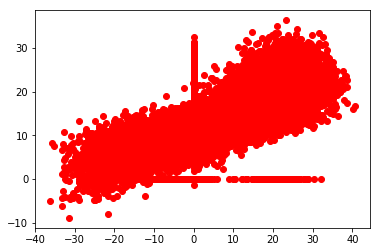

In [14]:
## let's try to plot victoria vs. saskatoon, max tempterature
import matplotlib.pyplot as plt
%matplotlib inline

## saskatoon max temp on x-axis
X = [float(saskdict[x]['Max Temp (°C)']) for x in sdt]
Y = [float(victdict[x]['Max Temp (°C)']) for x in sdt]

plt.plot(X, Y, 'ro')

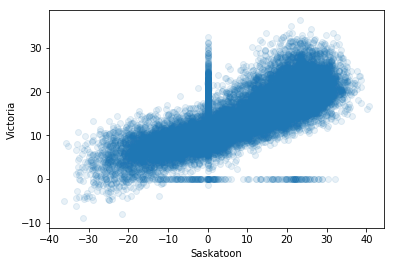

In [20]:
## better point plots in matplotlib
## scatter plots
plt.xlabel("Saskatoon")
plt.ylabel("Victoria")
plt.scatter(X, Y, alpha=0.1)

# Least squares

A useful technique for finding linear (and other) relations between variables is called *least squares*. 

Assume you have some data points $(x_i, y_i)$ for $i = 1, 2, \cdots, n$.  And you want to find a *best* fit function of the form

$$y \simeq F(x) = \sum_{i=1}^m c_i f_i(x)$$

with the functions $f_i : \mathbb R \to \mathbb R$ picked by you, i.e. we want to interpolate our data as a linear combination of some functions that we have decided upon *ahead of time*.

Given a choice of constants $\{c_i : i = 1, 2, \cdots, m\}$ the **Total Error** (squared) of the approximation is defined as:

$$E^2 = \sum_{i=1}^n (F(x_i) - y_i)^2 $$

Since $F$, $x_i$, and $y_i$ are given, we can think of $E^2$ as a function of the coefficients $(c_1, c_2, \cdots, c_m)$.  By calculus the minimum occurs at a critical point, which is when:

$$\frac{\partial E^2}{\partial c_1} = \frac{\partial E^2}{\partial c_2} = \cdots = \frac{\partial E^2}{\partial c_m} = 0 \hskip 1cm \star$$

which is a system of $m$ linear equations in the $m$ variables $\{c_1, c_2, \cdots, c_m\}$.

Specifically,

$$\frac{\partial E^2}{\partial c_k} = \sum_{i=1}^n 2(F(x_i)-y_i)f_k(x_i), \hskip 1cm k=1,2,\cdots, m$$
which allows us to express the linear system $\star$ as

$$\sum_{i,j=1}^{n,m} c_jf_j(x_i)f_k(x_i) = \sum_{i=1}^n y_i f_k(x_i), \hskip 1cm k=1,2,\cdots,n$$
which in turn is the matrix equation

$$AA^T \vec c = A \vec y$$
where
$$A = \begin{pmatrix}f_1(x_1) & f_1(x_2) & \cdots & f_1(x_n) \cr f_2(x_1) & f_2(x_2) & \cdots & f_2(x_n) \cr . & . & & . \cr  . & . & & . \cr f_m(x_1) & f_m(x_2) & \cdots & f_m(x_n)\end{pmatrix}$$
$\vec y = \begin{pmatrix}y_1 \cr y_2 \cr . \cr . \cr y_n\end{pmatrix}$, and
$\vec c = \begin{pmatrix}c_1 \cr c_2 \cr . \cr . \cr c_m\end{pmatrix}$.

Thus the solution is

$$ \vec c = (AA^T)^{-1} A \vec y$$

which exists when the $m \times m$ matrix $AA^T$ is invertible, which is equivalent to saying $A$ has rank $m$. One way to think of this is that the functions $f_1, \cdots, f_m$ should be linearly independent and this linear independence remains when you restrict these functions to the finite set $\{x_1, x_2, \cdots, x_n\}$.


In [21]:
## numpy matrices
import numpy as np
## linear approximation f0 = 1, f1 = x
## quadratic f0 = 1, f1 = x, f2 = x**2
## .T is transpose
A = np.matrix([[1.0, x, x**2] for x in X]).T
print(A.shape)

(3, 17897)


In [22]:
y = np.matrix(Y).T
print(y.shape)

(17897, 1)


In [23]:
c = np.linalg.inv(A*A.T)*A*y

In [24]:
print(c.shape)

(3, 1)


In [25]:
print(c)

[[1.10402113e+01]
 [3.29222728e-01]
 [1.54988979e-03]]


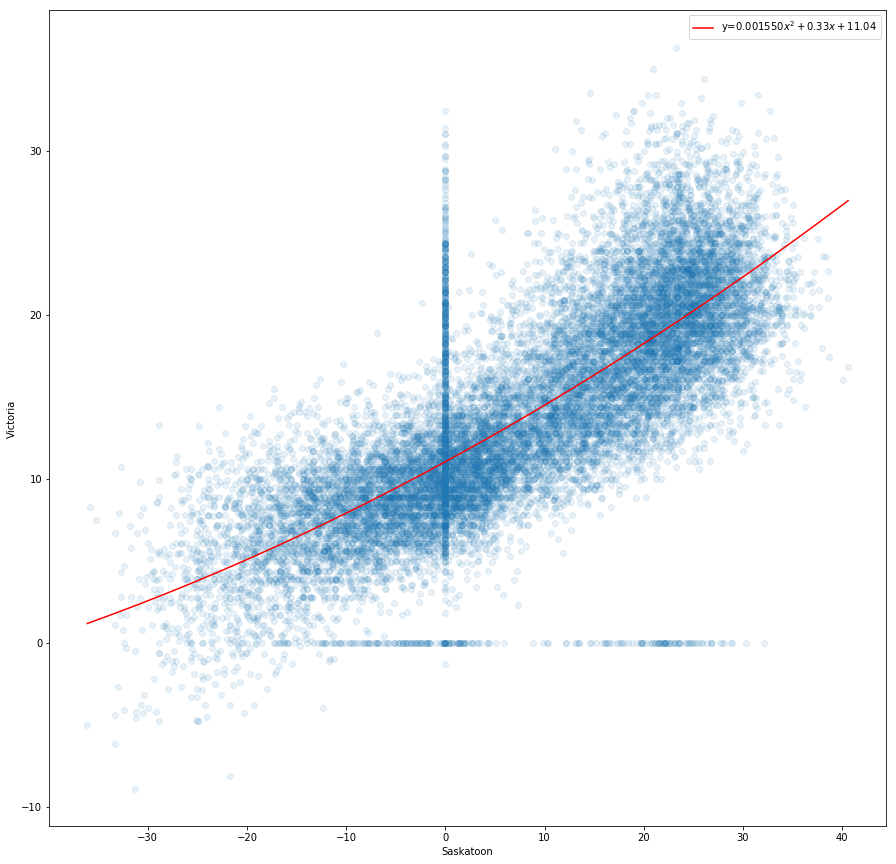

In [37]:
plt.figure(figsize=(15,15))
plt.xlabel("Saskatoon")
plt.ylabel("Victoria")
plt.scatter(X, Y, alpha=0.1)
dom = np.linspace(min(X), max(X), 1000)
ran = [c[0,0] + c[1,0]*x + c[2,0]*x**2 for x in dom]
plt.plot(dom, ran, 'r-', label='y=$%2.6fx^2+%2.2fx+%2.2f$' %(c[2,0],c[1,0], c[0,0]))
plt.legend()
plt.show()